In [1]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

model = ARIMAResults.load('model.pkl')

In [2]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append("/Users/ryan/Desktop/work/school intern/Energy Intern /eco-tools/") #path to PI CLient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import requests
import seaborn as sns 
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
#print(mnv.version)  # Last updated for mnv v2.0.1
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import style
style.use('fivethirtyeight')
from datetime import datetime as dt
import datetime

In [5]:
pc = pi_client(root='readonly') #assgin values
points = "GBSF_Electricity_Demand_kBtu" #GBSF_ChilledWater_Demand_kBtu
# use electricity data 

start = dt.now() - datetime.timedelta(days = 5)
start = start.strftime('%Y-%m-%d')

end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'

In [6]:
df = pc.get_stream_by_point(points,  start = start, 
                            end = end,calculation=calculation,
                            interval=interval)
df = df[np.isfinite(df).all(1)]

Grabbing WebIDs ...
WebID collection complete!
15:25:21: Sending API request... Chunk 1 of 1
15:25:21: Response recieved for 1 tags! (0.04)


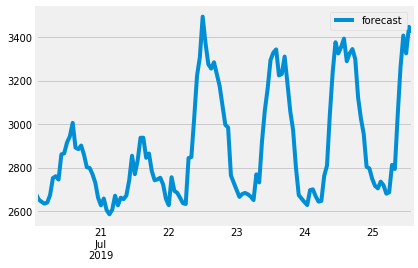

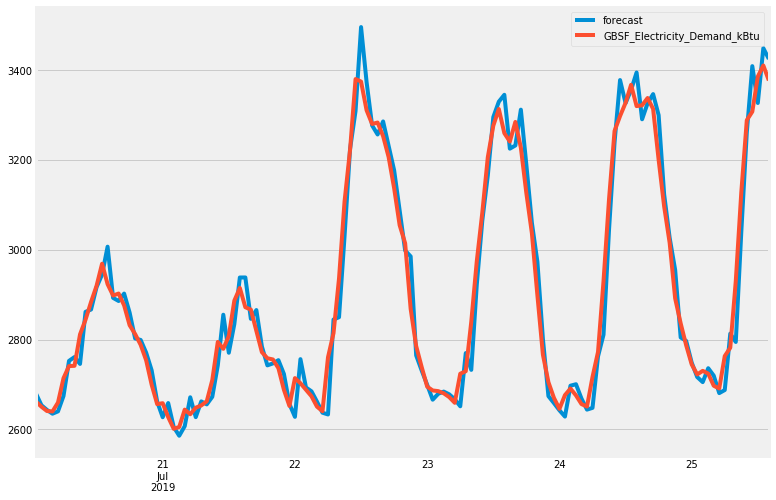

In [7]:
from statsmodels.tsa.arima_model import ARIMA

# fit model, determine the order, p , d , q
model = ARIMA(df.iloc[:,0], order=(2,1,2))
model_fit = model.fit(disp=0)
# make prediction
#yhat = model_fit.predict(len(df), len(df), typ='levels')
#print(yhat)
model_fit.plot_predict(dynamic=False,plot_insample = False)
model_fit.plot_predict(dynamic=False)
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

In [8]:
predicted_value = model_fit.predict(dynamic=False,typ = 'levels')
difference_value = model_fit.predict(dynamic=False)

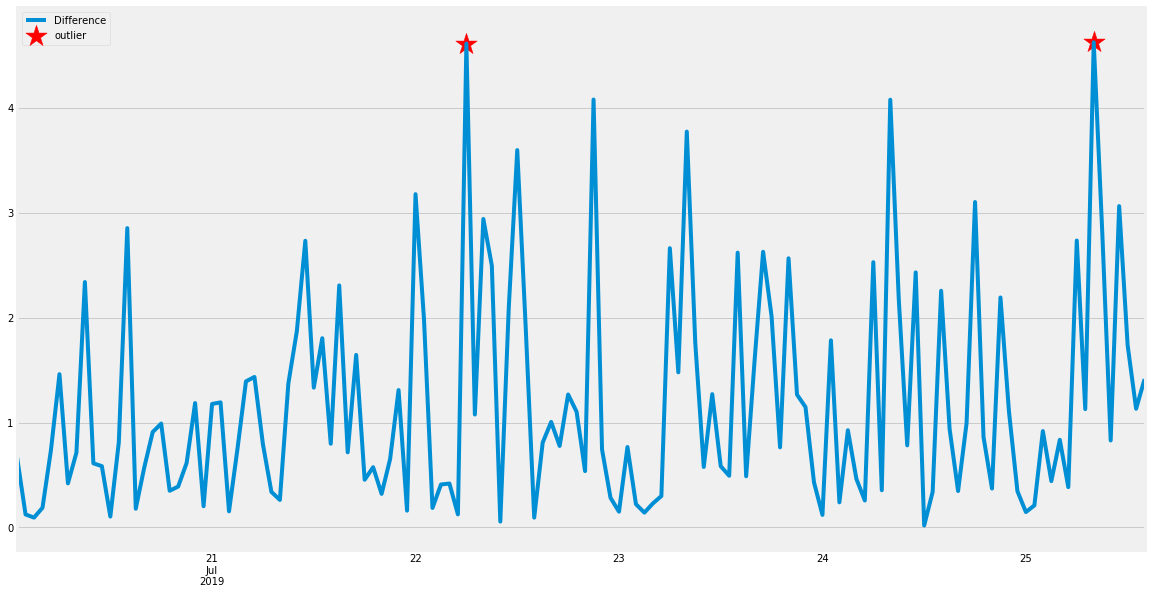

In [9]:
entirepredictdata = pd.concat([df,predicted_value],axis = 1)
entirepredictdata.dropna(inplace = True)
entirepredictdata.columns = ['Actual', 'Modeled']
entirepredictdata.eval('Difference = (Actual - Modeled)/ Actual * 100', inplace=True)
entirepredictdata["Difference"] = entirepredictdata['Difference'].abs()
entirepredictdata.head(3)
entirepredictdata.Difference.plot(figsize = (18, 10))

def detect_outlier(dataframe, threshold=3):
   dataframe = pd.DataFrame(dataframe)
   mean_1 = dataframe.mean()[0]
   std_1 = dataframe.std()[0]
   dataframe['zscore'] = (dataframe.values - mean_1)/std_1
   dataframe['outlier'] = np.nan
   dataframe.loc[(np.abs(dataframe.zscore) > threshold), 'outlier'] = dataframe.iloc[:,0].loc[(np.abs(dataframe.zscore) > threshold)]
   dataframe.drop(columns='zscore', inplace=True)
   return dataframe

outlier_data = detect_outlier(entirepredictdata["Difference"])

plt.scatter(outlier_data.index, outlier_data.outlier, color='red', marker='*', s=500)

plt.legend()
plt.show()


from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
 
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

model_fit.save('model.pkl')